<small><i>Updated February 2023 - This notebook was created by [Santi Seguí](https://ssegui.github.io/). </i></small>

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

## Let's create a Non-Personalised Recommender using MovieLens Dataset
We will work with the well known MovieLens dataset (http://grouplens.org/datasets/movielens/). This dataset was initially constructed to support participants in the Netflix Prize. Today, we can find several versions of this dataset with different amout of data, from 100k samples version to 20m sample version. Although performance on bigger dataset is expected to be better, we will work with the smallest dataset: MovieLens 100K Dataset (ml-100k-zip). Working with this lite version has the benefit of less computational costs

With a unix machine the dataset can be downloaded with the following code:


### We will use the Movielens 1 million dataset. We download it and uncompress the file we need.

In [2]:
!wget http://files.grouplens.org/datasets/movielens/ml-1m.zip 
!unzip ml-1m.zip -d "data/"

/bin/bash: wget: command not found
Archive:  ml-1m.zip
replace data/ml-1m/movies.dat? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


If you are working with a windows machine, please go to the website and download the ml-1m version and extract it to the subdirectory named "data/ml-1m/"

Once you have downloaded and unzipped the file into a directory, you can create a DataFrame with the following code:

In [3]:
#NETFLIX REAL 50.000.000 usuaris and 100.000 items
%autosave 150
%matplotlib inline
import pandas as pd
import numpy as np
import math
import matplotlib.pylab as plt

# Load Data set
u_cols = ['user_id', 'age', 'sex', 'occupation', 'zip_code']
users = pd.read_csv('./data/ml-1m/users.dat', sep='::', names=u_cols)

r_cols = ['user_id', 'movie_id', 'rating', 'unix_timestamp']
ratings = pd.read_csv('./data/ml-1m/ratings.dat', sep='::', names=r_cols)

# the movies file contains columns indicating the movie's genres
# let's only load the first three columns of the file with usecols
m_cols = ['movie_id', 'title', 'release_date',]
movies = pd.read_csv('./data/ml-1m/movies.dat', sep='::', names=m_cols, usecols=range(3), encoding='latin-1')

# Construcció del DataFrame
data = pd.merge(pd.merge(ratings, users), movies)
data = data[['user_id','title', 'movie_id','rating','release_date','sex','age']]


n_users = data.user_id.nunique()
n_items = data.movie_id.nunique()
print("La BD has "+ str(data.shape[0]) +" ratings")
print("La BD has ", n_users," users")
print("La BD has ", n_items, " movies")
data.head()


Autosaving every 150 seconds


/var/folders/df/4599m83s2vj4j1_h__gx7kqw0000gn/T/ipykernel_9044/3023940413.py:11: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  users = pd.read_csv('./data/ml-1m/users.dat', sep='::', names=u_cols)
/var/folders/df/4599m83s2vj4j1_h__gx7kqw0000gn/T/ipykernel_9044/3023940413.py:14: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  ratings = pd.read_csv('./data/ml-1m/ratings.dat', sep='::', names=r_cols)
/var/folders/df/4599m83s2vj4j1_h__gx7kqw0000gn/T/ipykernel_9044/3023940413.py:19: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char

La BD has 1000209 ratings
La BD has  6040  users
La BD has  3706  movies


,user_id,title,movie_id,rating,release_date,sex,age
0,1,One Flew Over the Cuckoo's Nest (1975),1193,5,Drama,1,F
1,2,One Flew Over the Cuckoo's Nest (1975),1193,5,Drama,56,M
2,12,One Flew Over the Cuckoo's Nest (1975),1193,4,Drama,25,M
3,15,One Flew Over the Cuckoo's Nest (1975),1193,4,Drama,25,M
4,17,One Flew Over the Cuckoo's Nest (1975),1193,5,Drama,50,M


If you explore the dataset in detail, you will see that it consists of:

1.000.209 ratings from 6040 users of 3706 movies. Ratings are from 1 to 5.
Simple demographic info for the users (age, gender, occupation, zip)

In [4]:
print ("Average interactions per user {:.2f}".format(data.shape[0]/n_users))
print ("Average interactions per item {:.2f}".format(data.shape[0]/n_items))

print ("Sparsity {:.2f} %".format((1- data.shape[0]/(n_items*n_users))*100))


Average interactions per user 165.60
Average interactions per item 269.89
Sparsity 95.53 %


### Ranking by polularity
We compute the item popularity as the number of interaction in each column


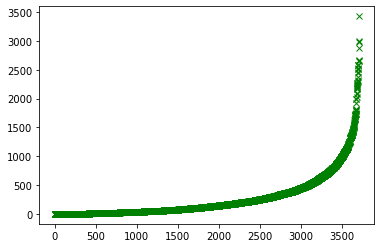

In [5]:
mean_score = data.groupby(['movie_id'])[['rating','movie_id']].agg({'rating':'mean',
                                                              'movie_id':'count'}).rename(columns = {'rating': 'mean_rating','movie_id':'num_ratings'})

item_popularity = mean_score.sort_values(by='num_ratings',ascending=True)['num_ratings'].values

plt.plot(item_popularity,'gx')
plt.show()

In [6]:
ten_percent = int(n_items/10)

print("Average per-item interactions over the whole dataset {:.2f}".
      format(item_popularity.mean()))

print("Average per-item interactions for the top 10% popular items {:.2f}".
      format(item_popularity[-ten_percent:].mean()))

print("Average per-item interactions for the least 10% popular items {:.2f}".
      format(item_popularity[:ten_percent].mean()))

print("Average per-item interactions for the median 10% popular items {:.2f}".
      format(item_popularity[int(n_items*0.45):int(n_items*0.55)].mean()))

Average per-item interactions over the whole dataset 269.89
Average per-item interactions for the top 10% popular items 1199.74
Average per-item interactions for the least 10% popular items 2.85
Average per-item interactions for the median 10% popular items 123.66


## We compute the user activity (profile length) as the number of interaction in each row

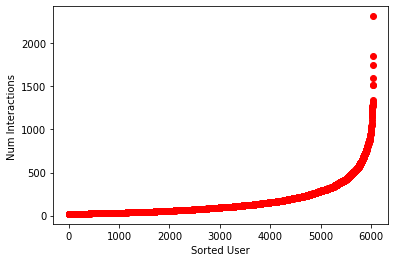

In [7]:
user_activity = data[['user_id','rating']].groupby(['user_id']).count()
user_activity = np.sort(user_activity.rating.values)

plt.plot(user_activity, 'ro')
plt.ylabel('Num Interactions ')
plt.xlabel('Sorted User')
plt.show()

## In order to create a Recommender we have to define:
* A splitting of the data
* An evaluation metric
* A function to evaluate for each user

## The splitting of the data is very important to ensure your algorithm is evaluated in a realistic scenario by using test it has never seen. 
We create two splits:
* Train
* Test

In [27]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(data, test_size=0.2, random_state=7)

## Evaluation metric
We call items in the test set 'relevant'


In [28]:
# These are the relevat items for one user

user_id = 1
relevant_items = test[test.user_id==user_id].movie_id.values
relevant_items

array([2294, 1035,  919, 1907, 2028,  914,  531,  720,  260, 1270, 1207,
       2018, 1028])

In [29]:
# let's imagin our recommender sytes recommend the following item
recommended_items = np.array([241, 2028, 114, 857, 1823])
recommended_items

array([ 241, 2028,  114,  857, 1823])

In [30]:
is_relevant = np.in1d(recommended_items, relevant_items, assume_unique=True)
is_relevant

array([False,  True, False, False, False])

## We can use several metrics. 
These are some of the most classical ones:
* Precision
* Recall
* Average Precison


## Precision: how many of the recommended items are relevant

In [31]:
def precision(recommended_items, relevant_items):
    
    is_relevant = np.in1d(recommended_items, relevant_items, assume_unique=True)
    
    precision_score = np.sum(is_relevant, dtype=np.float32) / len(is_relevant)
    
    return precision_score

## Recall: how many of the relevant items I was able to recommend

In [32]:
def recall(recommended_items, relevant_items):
    
    is_relevant = np.in1d(recommended_items, relevant_items, assume_unique=True)
    
    recall_score = np.sum(is_relevant, dtype=np.float32) / relevant_items.shape[0]
    
    return recall_score

## Average Precision

In [33]:
def AP(recommended_items, relevant_items):
   
    is_relevant = np.in1d(recommended_items, relevant_items, assume_unique=True)
    
    # Cumulative sum: precision at 1, at 2, at 3 ...
    p_at_k = is_relevant * np.cumsum(is_relevant, dtype=np.float32) / (1 + np.arange(is_relevant.shape[0]))
    
    ap_score = np.sum(p_at_k) / np.min([relevant_items.shape[0], is_relevant.shape[0]])

    return ap_score

## Now that we have the data, we can build our first recommender. We need two things:
* a'fit' function to train our model
* a 'recommend' function that uses our model to recommend

## Let's start with a random recommender


In [34]:
class RandomRecommender():

    def fit(self, train):
        
        self.items = train.title.unique()
    
    def recommend(self, user_id, at=5):
    
        recommended_items = np.random.choice(self.items, at)
        return recommended_items

In [35]:
randomRecommender = RandomRecommender()
randomRecommender.fit(train)

for user_id in range(10):
    print(randomRecommender.recommend(user_id, at=5))

['Mad Max Beyond Thunderdome (1985)' 'Iron Eagle IV (1995)'
 'Very Brady Sequel, A (1996)' 'Patch Adams (1998)'
 'Vagabond (Sans toit ni loi) (1985)']
['Airport (1970)' 'Bringing Out the Dead (1999)'
 'Man Who Would Be King, The (1975)' 'Best Men (1997)' 'After Life (1998)']
['Firelight (1997)' 'Native Son (1986)' 'Sugar Town (1999)'
 'Turbo: A Power Rangers Movie (1997)' 'Pokémon the Movie 2000 (2000)']
['Heidi Fleiss: Hollywood Madam (1995)' 'My Favorite Season (1993)'
 'Mighty Joe Young (1949)' "All the King's Men (1949)" 'Snowriders (1996)']
['Curse of the Puppet Master (1998)' 'Gigi (1958)'
 'Old Man and the Sea, The (1958)' 'Robocop 3 (1993)'
 'Don Juan DeMarco (1995)']
['Pather Panchali (1955)' 'Farewell My Concubine (1993)'
 'Rush Hour (1998)' 'Scarlet Letter, The (1926)'
 'Gambler, The (A Játékos) (1997)']
['Tales From the Crypt Presents: Demon Knight (1995)'
 'Arachnophobia (1990)' 'Ghost Dog: The Way of the Samurai (1999)'
 'Diner (1982)' 'Graveyard Shift (1990)']
['Bamba, L

## Put all together in an evaluation function and let's test it!


In [36]:
# We pass as paramether the recommender class

def evaluate_algorithm(test, recommender_object, at=5):
    
    cumulative_precision = 0.0
    cumulative_recall = 0.0
    cumulative_AP = 0.0
    num_eval = 0

    for user_id in test.user_id.unique():

        relevant_items = test[test.user_id==user_id].title.values
    
        if len(relevant_items)>0:
            
            recommended_items = recommender_object.recommend(user_id, at=at)
            num_eval+=1

            cumulative_precision += precision(recommended_items, relevant_items)
            cumulative_recall += recall(recommended_items, relevant_items)
            cumulative_AP += AP(recommended_items, relevant_items)
            
    cumulative_precision /= num_eval
    cumulative_recall /= num_eval
    MAP = cumulative_AP / num_eval
    
    print("Recommender results are: Precision = {:.4f}, Recall = {:.4f}, MAP = {:.4f}".format(
        cumulative_precision, cumulative_recall, MAP)) 

In [37]:
evaluate_algorithm(test, randomRecommender)

Recommender results are: Precision = 0.0087, Recall = 0.0013, MAP = 0.0041


### Everything works but for sure it can be improved..

## Let's build a TOP POPULAR RECOMMENDER

We **recommend to all users the most popular items**, that is those with the **highest number of interactions**
In this case our model is the item popularity.


In [38]:
class TopPopRecommender(object):

    def fit(self, train):
        # YOUR CODE HERE!
        
        self.items = train.title.unique()
        interactions_per_movie = []
        for movie in self.items:
            reps = train[train.title == movie]
            interactions_per_movie.append(len(reps))
        
        self.interactions = interactions_per_movie
    
    def recommend(self, user_id, at=5):
        # YOUR CODE HERE!
        different_movies = pd.unique(train.title)
        #print(len(self.interactions), len(self.items), print(len(different_movies))) 
        df = pd.DataFrame({
            'title': different_movies,
            'interactions': list(self.interactions)
        })
        df_sorted = df.sort_values(by = 'interactions', ascending=False)
        
        recommended_items = df_sorted.head(at).title
        return recommended_items

In [30]:
different_movies = pd.unique(train.title)
interactions_per_movie = [] # np.zeros(different_movies.shape[0])
for movie in different_movies:
    reps = train[train.title == movie]
    interactions_per_movie.append(len(reps))

In [41]:
print(len(interactions_per_movie))
print(len(different_movies))
df = pd.DataFrame({
    'title': different_movies,
    'interactions': interactions_per_movie
})
df_sorted = df.sort_values(by = 'interactions', ascending=False)   
df_sorted.head(5).title

3680
3680


93                                American Beauty (1999)
37     Star Wars: Episode V - The Empire Strikes Back...
224            Star Wars: Episode IV - A New Hope (1977)
847    Star Wars: Episode VI - Return of the Jedi (1983)
282                                 Jurassic Park (1993)
Name: title, dtype: object

In [42]:
df_sorted.head(5)

,title,interactions
93,American Beauty (1999),2793
37,Star Wars: Episode V - The Empire Strikes Back...,2433
224,Star Wars: Episode IV - A New Hope (1977),2354
847,Star Wars: Episode VI - Return of the Jedi (1983),2299
282,Jurassic Park (1993),2132


In [39]:
topPopRecommender = TopPopRecommender()
topPopRecommender.fit(train)

In [26]:
for user_id in range(10):
    print(topPopRecommender.recommend(user_id, at=5))

NameError: name 'interactions_per_movie' is not defined

In [22]:
evaluate_algorithm(test, topPopRecommender, at=5)

Recommender results are: Precision = 0.0000, Recall = 0.0000, MAP = 0.0000


## What if we only recommend unseen items?

In [23]:
class TopPopRecommender():

    def fit(self, train):
        # YOUR CODE HERE!
        self.items = train.title.unique()
        interactions_per_movie = []
        for movie in self.items:
            reps = train[train.title == movie]
            interactions_per_movie.append(len(reps))
        
        self.interactions = interactions_per_movie

    
    def recommend(self, user_id, at=5):
        # YOUR CODE HERE!
        different_movies = pd.unique(train.title)
        df = pd.DataFrame({
            'title': different_movies,
            'interactions': list(self.interactions)
        })
        
        movies_seen = train[train.user_id == user_if]
        movies_seen_name = pd.unique(train.title)
        
        df_sorted = df.sort_values(by = 'interactions', ascending=False)
        df_not_seen = df_sorted[~df_sorted['title'].isin(movies_seen_name)]
        
        
        recommended_items = df_not_seen.head(at).title
        return recommended_items

In [24]:
topPopRecommender_removeSeen = TopPopRecommender()
topPopRecommender_removeSeen.fit(train)

for user_id in range(5):
    print(topPopRecommender_removeSeen.recommend(user_id, at=5))

None
None
None
None
None


In [25]:
evaluate_algorithm(test, topPopRecommender_removeSeen)

Recommender results are: Precision = 0.0000, Recall = 0.0000, MAP = 0.0000


##  Let's build a HIGHEST RATED RECOMMENDER
We recommend to all users the items with the highest mean rating.
In this case our model is the item mean rating

In [26]:
globalAverage = train.rating.mean()
print("The global average is {:.2f}".format(globalAverage))

The global average is 3.58


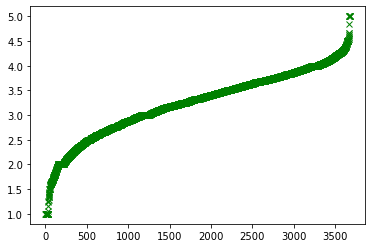

In [27]:
mean_item_rating = train[['movie_id','rating']].groupby(by ='movie_id').mean().rating.values
plt.plot(np.sort(mean_item_rating),'gx')

In [28]:
class HighestRatedRecommender():

    def fit(self, train, k = 10):
        
        # YOUR CODE HERE!
        pass
    
    def recommend(self, user_id, at=5, remove_seen=True):

        # YOUR CODE HERE!
        pass

In [29]:
highestScoreRecommender_removeSeen = HighestRatedRecommender()
highestScoreRecommender_removeSeen.fit(train)

for user_id in range(5):
    print(highestScoreRecommender_removeSeen.recommend(user_id, at=5))
    
evaluate_algorithm(test, highestScoreRecommender_removeSeen)

None
None
None
None
None
Recommender results are: Precision = 0.0000, Recall = 0.0000, MAP = 0.0000


## Does it work? Any idea to improve it?
* HINT 1: we should penalize those items that has been rated by only few users
* HINT 2: Each user has different mean rating.. perhaps, we should remove user_bias

In [30]:
## YOUR IMPROVED MODEL HERE

## Let's change the meaning of relevant!
A relevant item should be something with high score

In [31]:
# We pass as paramether the recommender class

def evaluate_algorithm_top(test, recommender_object, at=5, thr_relevant = 4):
    
    cumulative_precision = 0.0
    cumulative_recall = 0.0
    cumulative_AP = 0.0
    
    num_eval = 0


    for user_id in test.user_id.unique():

        relevant_items = test[(test.user_id==user_id )&( test.rating>=thr_relevant)].title.values
        
        if len(relevant_items)>0:
            
            recommended_items = recommender_object.recommend(user_id, at=at)
            num_eval+=1

            cumulative_precision += precision(recommended_items, relevant_items)
            cumulative_recall += recall(recommended_items, relevant_items)
            cumulative_AP += AP(recommended_items, relevant_items)
            
    cumulative_precision /= num_eval
    cumulative_recall /= num_eval
    MAP = cumulative_AP / num_eval
    
    print("Recommender results are: Precision = {:.4f}, Recall = {:.4f}, MAP = {:.4f}".format(
        cumulative_precision, cumulative_recall, MAP)) 

In [32]:
## EVALUTE YOUR MODELS WITH THIS NEW STRATEGY

## Conclusions
 * Why is Highest score is performing worse than TopPop even if we are taking into account more information about the interaction?


Sometimes ratings are not really more informative than interactions. The community has been moving away from explicit ratings for a decade now, preferring implicit interactions that are easier to collect and more reliable.
Generally speaking, "more information" is not necessarily better if noisy or hard to model.